In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy
import time
from algo.upper_level_utils import *
from scipy.optimize.lbfgsb import fmin_l_bfgs_b

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = (1+0j)*u0.data[125:175,125:175]

In [4]:
n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(u0_mat)+1e-7*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [5]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radial_p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
radial_p[n*ind1+ind2]=1
radial_p[-1]=1e-6
p = np.copy(radial_p)

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=3,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"pn1":p[-1],"epsilon":1e-5,"gamma":1e-10}


In [6]:
pysap.Image(data=np.reshape(radial_p[:-1],(n,n))).show()

In [7]:
print(ssim(fourier_op.adj_op(p[:-1]*y),u0_mat))
pysap.Image(data=fourier_op.adj_op(p[:-1]*y)).show()

0.9859580589314733


In [8]:
linear_op.op(u0_mat).shape

/home/guillaume/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


(2578,)

# Definition of functions
Only for one linear operator for the moment (wavelet).

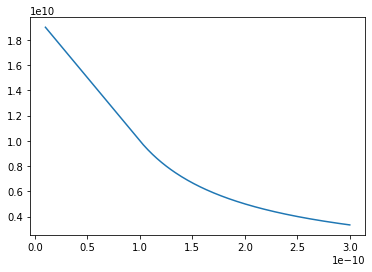

In [9]:
x = np.linspace(0.1*param["gamma"],3*param["gamma"],200)
plt.plot(x,phi_vec(x,param["gamma"]))

In [10]:
psix_vec(np.array([1+1j]),1e-10)

array([-0.35355339-0.35355339j])

# Functions and first order derivatives

In [11]:
#Base functions
def Eeps(x,p):return param["epsilon"]/2*np.linalg.norm(x)**2
def Edata(x,p):return 0.5*np.linalg.norm(p[:-1]**2*(fourier_op.op(x)-y))**2
def Ereg(x,p):return p[-1]*np.sum(rho_vec(np.abs(linear_op.op(x)),param["gamma"]))
def Etot(x,p):return Eeps(x,p)+Edata(x,p)+Ereg(x,p)

#First order derivatives
def Du_Eeps(x,p):return param["epsilon"]*x
def Du_Edata(x,p):return fourier_op.adj_op(p[:-1]*(fourier_op.op(x)-y))
def Du_Ereg(x,p):return p[-1]*linear_op.adj_op(phix_vec(linear_op.op(x),param["gamma"]))
def Du_Etot(x,p):return Du_Eeps(x,p)+Du_Edata(x,p)+Du_Ereg(x,p)

### Numerical check
Plots of $\left|\frac{f(a+th)-f(a)-<\mathcal{Re}(\nabla f(a)),\mathcal{Re}(th)>-<\mathcal{Im}(\nabla f(a)),\mathcal{Im}(th)>}{t}\right|$ for $t\rightarrow 0$.

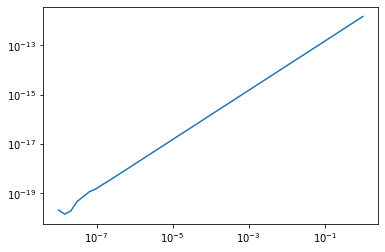

In [12]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-8,0,50)
real_values = np.array([Eeps(a+t*a2,radial_p) for t in tests])
approx = np.array([Eeps(a,radial_p)+t*np.sum(np.real(Du_Eeps(a,radial_p))*np.real(a2)+
                                          np.imag(Du_Eeps(a,radial_p))*np.imag(a2)) for t in tests])

plt.plot(tests,np.abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

1.8695110037382103e-07


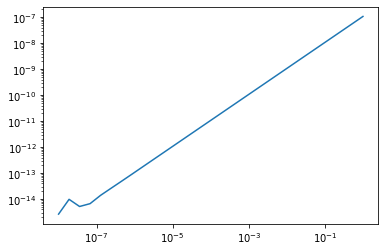

In [13]:
# -- Edata --
#Random vector with same amplitude as u0
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

p=radial_p
tests = np.logspace(-8,0,30)
real_values = np.array([Edata(a+t*a2,p) for t in tests])
approx = np.array([Edata(a,p)+np.sum(np.real(Du_Edata(a,radial_p))*np.real(t*a2)+
                                          np.imag(Du_Edata(a,radial_p))*np.imag(t*a2)) for t in tests])

print(Edata(a,radial_p))
plt.plot(tests,np.abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

2.5336976944870357e-08


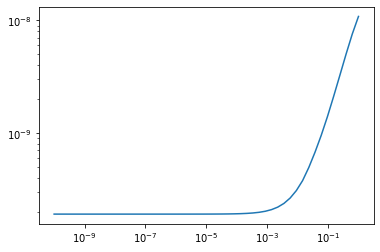

In [14]:
# -- Ereg --
#Random vector with same amplitude as u0
a = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-10,0,50)
real_values = np.array([Ereg(a+t*a2,radial_p) for t in tests])
approx = np.array([Ereg(a,radial_p)+t*np.sum(np.real(Du_Ereg(a,radial_p))*np.real(a2)+
                                          np.imag(Du_Ereg(a,radial_p))*np.imag(a2)) for t in tests])

print(Ereg(a,radial_p))
plt.plot(tests,np.abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

1.9021845366269424e-20


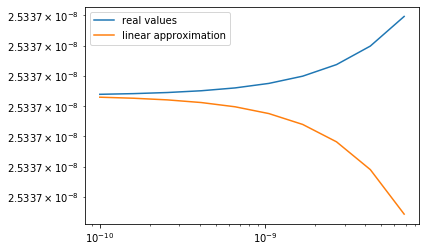

In [15]:
print(real_values[0]-approx[0])
limit = 10
plt.plot(tests[:limit],real_values[:limit],label="real values")
plt.plot(tests[:limit],approx[:limit],label="linear approximation")
plt.xscale("log")
plt.yscale("log")
plt.legend()

2.1316652784713154e-07


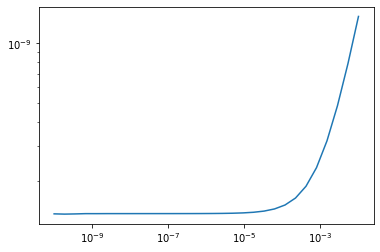

In [16]:
# -- Etot --
#Random vector with same amplitude as u0
a = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n*n).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-10,-2,30)
real_values = np.array([Etot(a+t*a2,radial_p) for t in tests])
approx = np.array([Etot(a,radial_p)+t*np.sum(np.real(Du_Etot(a,radial_p))*np.real(a2)+
                                          np.imag(Du_Etot(a,radial_p))*np.imag(a2))for t in tests])

print(Etot(a,radial_p))
plt.plot(tests,np.abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

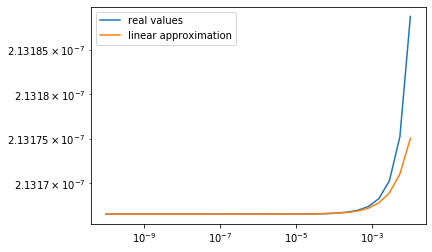

In [17]:
plt.plot(tests,real_values,label="real values")
plt.plot(tests,approx,label="linear approximation")
plt.xscale("log")
plt.yscale("log")
plt.legend()

# Second order derivatives
We don't express the hessians as matrices but as linear operators.

In [18]:
def Du2_Eeps(u,p,w):return param["epsilon"]*w
def Du2_Edata(u,p,w):return fourier_op.adj_op(p[:-1]**2*fourier_op.op(w))
def Du2_Ereg(u,p,w):
    lin_u = linear_op.op(u)
    lin_w = linear_op.op(w)
    psix_Au = psix_vec(lin_u,param["gamma"])
    phi_Au = phi_vec(np.abs(lin_u),param["gamma"])
    
    part1 = psix_Au*(np.real(lin_u)*np.real(lin_w)+np.imag(lin_u)*np.imag(lin_w))
    part2 = phi_Au*lin_w
    return p[-1]*(linear_op.adj_op(part1+part2))
def Du2_Etot(u,p,w):return Du2_Eeps(u,p,w)+Du2_Edata(u,p,w)+Du2_Ereg(u,p,w)

5.499215808567982e-09


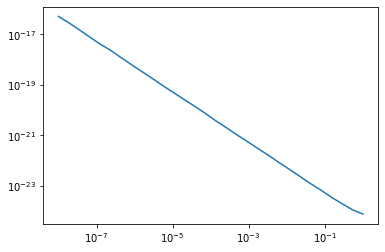

In [19]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

ntest=30
tests = np.logspace(-8,0,ntest)
Dua = Du_Eeps(a,p)
real = []
approx = []
for t in tests:
    real.append(Du_Eeps(a+t*a2,p))
    approx.append(Dua+Du2_Eeps(a,p,t*a2))

print(np.linalg.norm(Dua))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

0.000613855068755142


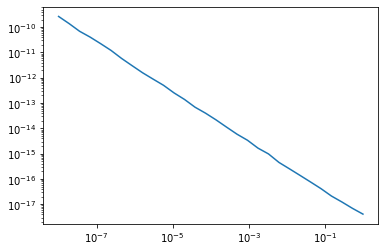

In [20]:
# -- Edata --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

ntest=30
tests = np.logspace(-8,0,ntest)
real = []
approx = []
Dua = Du_Edata(a,radial_p)
for t in tests:
    real.append(Du_Edata(a+t*a2,radial_p))
    approx.append(Dua+t*Du2_Edata(a,radial_p,a2))

print(np.linalg.norm(Dua))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

5.0175091690927434e-05


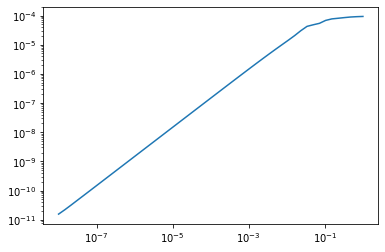

In [21]:
# -- Ereg --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

ntest=50
tests = np.logspace(-8,0,ntest)
real = []
approx = []
Dua = Du_Ereg(a,radial_p)
for t in tests:
    real.append(Du_Ereg(a+t*a2,radial_p))
    approx.append(Dua+Du2_Ereg(a,radial_p,t*a2))

print(np.linalg.norm(Dua))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

0.0006281514866613693


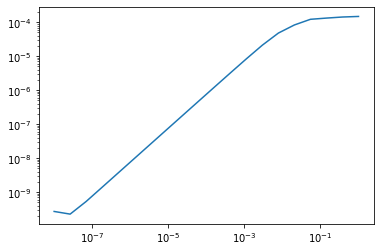

In [22]:
# -- Etot --
#Two random vectors with same amplitude
a = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(2*n**2).view(np.complex128).reshape((n,n))/n*np.linalg.norm(u0_mat)

ntest=20
tests = np.logspace(-8,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Etot(a+t*a2,p))
    approx.append(Du_Etot(a,p)+t*Du2_Etot(a,p,a2))

print(np.linalg.norm(Du_Etot(a,p)))
plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

## Cross derivatives

In [23]:
def Dpu_Edata(u,p,w):
    Fu = fourier_op.op(u)-y
    Fw = fourier_op.op(w)
    return 2*p[:-1]*(np.real(Fu)*np.real(Fw)+np.imag(Fu)*np.imag(Fw))
def Dpu_Ereg(u,p,w):
    return p[-1]*np.sum(np.comp(w)*linear_op.adj_op(phi_vec(linear_op.op(u),param["gamma"])*linear_op.op(u)))

def Dpu_Etot(u,p,w):
    g = np.zeros((n**2+1,))
    g[:-1] = Dpu_Edata(u,p,w)
    #Don't learn alpha for the moment
    g[-1] = 0
    #g[-1] = Dpu_Ereg(u,p,w)
    return g

## Loss function and penalty

In [24]:
c = 1e0
def L(u,u2):return c*np.sum(rho_vec(u-u2,param["gamma"]))
def grad_L(u,u2):return c*phix_vec(u-u2,param["gamma"])

beta = 0*c
def P(p):return beta*np.linalg.norm(p[:-1])**2
def grad_P(p):
    Dp = 2*beta*p
    Dp[-1] = 0
    return Dp

# def P(p):return beta*np.sum(p[:-1]*(2-p[:-1]))
# def grad_P(p):
#     Dp = np.zeros(n**2+1)
#     Dp[:-1] = 2*beta*(1-p[:-1])
#     return Dp

In [25]:
param["pn1"]=1e-6
p = np.copy(radial_p)
uk,norms,energy = pdhg(y,p[:-1],fourier_op,linear_op,param,maxit=20,verbose=0)
print(f"\nL(u(p))={L(uk,u0_mat)}\nP(p)={P(p)}")

Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.1562635898590088 seconds.

L(u(p))=0.001007844800514587
P(p)=0.0


/home/guillaume/pysap-mri/Lower Level/algo/prox.py:14: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


# Upper level energy

In [26]:
def E(pk):
    print("\nEvaluating E(p)")
    param["pn1"]=pk[-1]
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=20,verbose=0)
    return L(uk,u0_mat)+P(pk)

cgconv = []
def grad_E(pk,max_cgiter=1000,tol=1e-8,compute_conv=False):
    global cgconv
    #Update alpha(p)
    param["pn1"]=pk[-1]
    print("\nStarting PDHG")
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=50,verbose=0)
    
    #Defining linear operator from pk and uk
    def mv(w):
        w = np.reshape(w,(n,n))
        return np.reshape(Du2_Etot(uk,pk,w),(n**2,))
    
    
    # -- Use cg to compute gradient --
    lin = LinearOperator((n**2,n**2),matvec=mv)
    B = np.reshape(np.conj(grad_L(uk,u0_mat)),(n**2,)).transpose()
    def cgcall(x):
        if compute_conv:cgconv.append(np.linalg.norm(lin(x)-B)/np.linalg.norm(B))
    
    t1=time.time()
    print("\nStarting Conjugate Gradient method")
    x_inter,convergence = cg(lin,B,tol=tol,maxiter=max_cgiter,callback=cgcall)
    print(f"Finished in {time.time()-t1}s - ||Ax-b||/||b||: {np.linalg.norm(lin(x_inter)-B)/np.linalg.norm(B)}")
    
    #Apply DpuE
    return -Dpu_Etot(uk,pk,np.reshape(x_inter,(n,n)))+grad_P(pk)

# Callback function
niter = 0
def fcall(x):
    global uk,niter
    niter += 1
    print("\033[1m" + f"\n{niter} iterations: ssim={ssim(uk,u0_mat)}\n\n" + "\033[0m")

In [27]:
#Checking if conjugate gradient converges
p=0.9*radial_p+0.1*np.random.rand(n**2+1)
p[-1]=1e-6
gP = grad_E(p,max_cgiter=1000,tol=1e-10,compute_conv=True)


Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.29682421684265137 seconds.

Starting Conjugate Gradient method
Finished in 13.571943998336792s - ||Ax-b||/||b||: 63.71599477524663


Text(0, 0.5, '||Ax-b||/||b||')

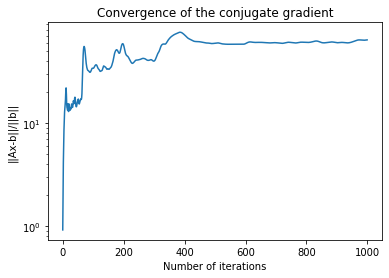

In [28]:
plt.plot(cgconv)
plt.yscale("log")
plt.title("Convergence of the conjugate gradient")
plt.xlabel("Number of iterations")
plt.ylabel("||Ax-b||/||b||")
#plt.savefig("Upper Level/CG_conv.png")

In [29]:
# Checking gradE
p0 = 0.9*radial_p+0.1*np.random.rand(n**2+1)
p0[-1] = 1e-6
Ep0,gradEp0 = E(p0),grad_E(p0)
p1 = np.random.rand(n**2+1)

tests = np.logspace(-15,0,50)
real_values = np.array([E(p0+t*p1) for t in tests])
approx = np.array([Ep0+t*np.sum(gradEp0*p1) for t in tests])


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.11708831787109375 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.282123327255249 seconds.

Starting Conjugate Gradient method
Finished in 7.231080055236816s - ||Ax-b||/||b||: 282.93623919137

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.15459752082824707 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.26357007026672363 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.12402153015136719 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.1285390853881836 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.1170358657836914 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.12790441513061523 seconds.

Evaluating E(p)
Sigma: 0.447213595499957


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.12735843658447266 seconds.
0.0010546241567747972


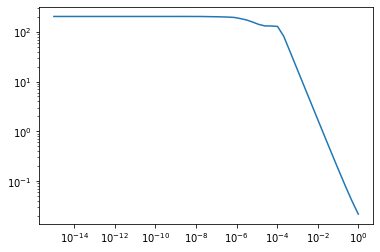

In [30]:
print(E(p0))
plt.plot(tests,abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

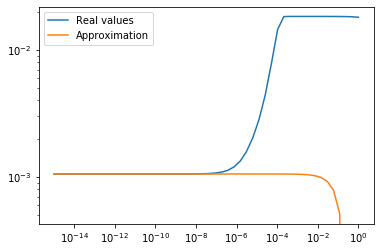

In [31]:
plt.plot(tests,real_values,label="Real values")
plt.plot(tests,approx,label="Approximation")
plt.xscale("log")
plt.yscale("log")
plt.legend()

# L-BFGS-B

In [32]:
p0 = 0.9*p+0.1*np.random.rand(n**2+1)
# p0 = np.random.rand(n**2+1)
# p0=np.ones(n**2+1)
p0[-1] = 1e-6

In [ ]:
niter = 0
pf,Emin,info = fmin_l_bfgs_b(E,p0,grad_E,bounds=[(0,1)]*n**2+[(0,np.inf)],pgtol=1e-15,
                           maxfun=1000,maxiter=1000,
                            callback = fcall)


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.14087557792663574 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.3204164505004883 seconds.

Starting Conjugate Gradient method
Finished in 7.418509006500244s - ||Ax-b||/||b||: 164.89546310032347

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.11080479621887207 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.43519043922424316 seconds.

Starting Conjugate Gradient method
Finished in 7.07012152671814s - ||Ax-b||/||b||: 159.08967590952906

1 iterations: ssim=0.9315565676489177



Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.11167526245117188 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.29758286476135254 seconds.

Starting Conjugate Gradient method
Finished in 6.699162244796753s - ||Ax-b||/||b||: 549.659098765337

2 iterat

In [ ]:
print(E(p0),E(pf))

In [ ]:
print(pf[-1])
pysap.Image(data=np.reshape(p0[:-1]-pf[:-1],(n,n))).show()

In [ ]:
np.sum(p0),np.sum(pf)

In [ ]:
uk,norms,energy,ssims = pdhg(y,pf[:-1],fourier_op,linear_op,param,ground_truth=u0_mat,maxit=100)
print(ssim(uk,u0_mat))

plt.figure()
plt.plot(ssims)
plt.title("Evolution of ssim")
plt.show()

plt.figure()
plt.plot(energy)
plt.title("Evolution of energy")
plt.yscale("log")
plt.show()

pysap.Image(data=uk).show()